In [12]:
from torch import nn, optim
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
!pip install optuna

     |████████████████████████████████| 293 kB 489 kB/s eta 0:00:01
     |████████████████████████████████| 80 kB 530 kB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 162 kB/s eta 0:00:01
     |████████████████████████████████| 75 kB 485 kB/s  eta 0:00:01
     |████████████████████████████████| 164 kB 785 kB/s eta 0:00:01
     |████████████████████████████████| 87 kB 730 kB/s eta 0:00:01
  Using cached python_editor-1.0.4-py3-none-any.whl (4.9 kB)
     |████████████████████████████████| 75 kB 570 kB/s eta 0:00:01
     |████████████████████████████████| 111 kB 443 kB/s eta 0:00:01
     |████████████████████████████████| 49 kB 350 kB/s eta 0:00:01
     |████████████████████████████████| 253 kB 311 kB/s eta 0:00:01
     |████████████████████████████████| 133 kB 418 kB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=211c8406df7773b86860c924c244fd78499d2bdf80a2b97c061bb0d338dc3075
  Stored in directory: /Users/luansilva

In [2]:
import optuna

In [13]:
#Network architecture
class Classifier(nn.Module):
    def __init__(self, node):
        super().__init__()
        self.fc1 = nn.Linear(784, node[0])
        self.fc2 = nn.Linear(node[0], node[1])
        self.fc3 = nn.Linear(node[1], node[2])
        self.fc4 = nn.Linear(node[2], 10)

        #20% probability Dropout 
        self.dropout = nn.Dropout(p=.2)

    def forward(self, x):
        #flatten input tensor
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [14]:
transform = transforms.ToTensor()

#Download and load training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

#Download and load test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

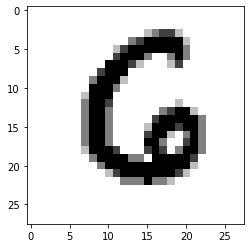

In [4]:
image, label = next(iter(trainLoader))
plt.imshow(image[0,:].reshape(28,28),cmap='binary')

In [27]:
def train(trial):
    
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-2)
    
    node_params = [
        trial.suggest_int('node0',200,400),
        trial.suggest_int('node1',300,500),
        trial.suggest_int('node2',100,300)
    ]
        
    model = Classifier(node_params)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 5
    steps = 0
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for imgs, labels, in trainLoader:
            logps = model(imgs)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            print(f"Training loss: {running_loss}")

            test_loss = 0
            acc = 0
            #Disable gradients for validation
            with torch.no_grad():
                #set model to evaluation mode (w/o dropout)
                model.eval()

                for imgs, labels in testLoader:
                    log_ps = model(imgs)
                    test_loss += criterion(log_ps, labels)
                    #class probability
                    ps = torch.exp(log_ps)
                    #most likely classes
                    top_p, top_class = ps.topk(1, dim=1)
                    #check if top classes matches with the labels
                    equals = top_class == labels.view(*top_class.shape)
                    #convert 'equals' to a float tensor
                    acc += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss/len(trainLoader))
            test_losses.append(test_loss/len(testLoader))
            print("Epoch: {}/{}.. ".format(e+1,epochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/len(trainLoader)),
                    "Test Loss: {:.3f}.. ".format(test_loss/len(testLoader)),
                    "Test Acc: {:.3f}.. ".format(acc/len(testLoader)))

            #set model back to train mode
            model.train()
            
    return acc

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(train, n_trials=3)

[I 2021-05-21 22:54:06,565] A new study created in memory with name: no-name-96079c2a-427c-4619-92f4-cef84acacb77


Training loss: 262.88513598404825
Epoch: 1/5..  Training Loss: 0.280..  Test Loss: 0.149..  Test Acc: 0.954.. 
Training loss: 118.87178183533251
Epoch: 2/5..  Training Loss: 0.127..  Test Loss: 0.092..  Test Acc: 0.971.. 
Training loss: 90.08182998350821
Epoch: 3/5..  Training Loss: 0.096..  Test Loss: 0.087..  Test Acc: 0.975.. 
Training loss: 76.47511644277256
Epoch: 4/5..  Training Loss: 0.082..  Test Loss: 0.072..  Test Acc: 0.979.. 
Training loss: 68.10430105484556


[I 2021-05-21 22:55:36,833] Trial 0 finished with value: 154.015625 and parameters: {'lr': 0.0013893455370850457, 'node0': 357, 'node1': 341, 'node2': 181}. Best is trial 0 with value: 154.015625.


Epoch: 5/5..  Training Loss: 0.073..  Test Loss: 0.070..  Test Acc: 0.981.. 
Training loss: 265.6224224604666
Epoch: 1/5..  Training Loss: 0.283..  Test Loss: 0.130..  Test Acc: 0.964.. 
Training loss: 160.83001809939742
Epoch: 2/5..  Training Loss: 0.171..  Test Loss: 0.133..  Test Acc: 0.963.. 
Training loss: 137.83144275518134
Epoch: 3/5..  Training Loss: 0.147..  Test Loss: 0.126..  Test Acc: 0.966.. 
Training loss: 126.7224253078457
Epoch: 4/5..  Training Loss: 0.135..  Test Loss: 0.107..  Test Acc: 0.972.. 
Training loss: 124.2035732138902


[I 2021-05-21 22:57:13,951] Trial 1 finished with value: 152.09375 and parameters: {'lr': 0.0039024604362195535, 'node0': 370, 'node1': 354, 'node2': 110}. Best is trial 0 with value: 154.015625.


Epoch: 5/5..  Training Loss: 0.132..  Test Loss: 0.116..  Test Acc: 0.969.. 
Training loss: 259.1056257970631
Epoch: 1/5..  Training Loss: 0.276..  Test Loss: 0.124..  Test Acc: 0.962.. 
Training loss: 113.61899766605347
Epoch: 2/5..  Training Loss: 0.121..  Test Loss: 0.089..  Test Acc: 0.973.. 
Training loss: 85.61906793736853
Epoch: 3/5..  Training Loss: 0.091..  Test Loss: 0.089..  Test Acc: 0.973.. 
Training loss: 71.43690823297948
Epoch: 4/5..  Training Loss: 0.076..  Test Loss: 0.080..  Test Acc: 0.977.. 
Training loss: 60.43583781516645


[I 2021-05-21 22:59:03,603] Trial 2 finished with value: 153.4375 and parameters: {'lr': 0.0011284948365188707, 'node0': 376, 'node1': 425, 'node2': 195}. Best is trial 0 with value: 154.015625.


Epoch: 5/5..  Training Loss: 0.064..  Test Loss: 0.077..  Test Acc: 0.977.. 


In [30]:
study.best_params

{'lr': 0.0013893455370850457, 'node0': 357, 'node1': 341, 'node2': 181}